In [3]:
import os

In [4]:
os.chdir('/home/ak/Projects/ature')

In [5]:
from commons.IMAGE import Image
from commons.ImgLATTICE import Lattice
import preprocess.utils.img_utils as imgutils
from commons.MAT import Mat
from PIL import Image as IMG
import numpy as np
from commons import constants as const

In [6]:
# os.chdir('/home/ak/Projects/ature/data/av_wide_data_set')
# file = Mat(file_name='wide_image_03.mat')
# original = file.get_image('I2')[:,:,:]
# img = Image(image_arr=original)

In [7]:
#Load image directly
os.chdir('/home/ak/Projects/ature/data/HD')
original1 = IMG.open('01_dr.JPG')
original1 = np.array(original1.getdata(), np.uint8).reshape(original1.size[1], original1.size[0], 3)
# img = Image(image_arr=original1[:,:,1][300:1300,400:2000])
img = Image(image_arr=original1[:,:,1])

In [8]:
#  IMG.fromarray(original).save('wide_image_03-RGB.png')
# IMG.fromarray(img.img_array)

In [9]:
img.apply_bilateral()

INFO:root:Applying Bilateral filter.


------[ RUNNING Time: 13.208496570587158 seconds ]------


In [10]:
# IMG.fromarray(img.diff_bilateral)

In [11]:
# Bilateral Filter Constants
BILATERAL_KERNEL_SIZE = 41
BILATERAL_SIGMA_COLOR = 20
BILATERAL_SIGMA_SPACE = 20

# Gabor filter Constants
GABOR_KERNEL_SIZE1 = 171
GABOR_KERNEL_GAMMA1 = 0.7
GABOR_KERNEL_LAMBDA1 = 25
GABOR_KERNEL_SIGMA1 = 9

GABOR_KERNEL_SIZE2 = 171
GABOR_KERNEL_GAMMA2 = 0.7
GABOR_KERNEL_LAMBDA2 = 50
GABOR_KERNEL_SIGMA2 = 16

GABOR_KERNEL_SIZE3 = 171
GABOR_KERNEL_GAMMA3 = 0.7
GABOR_KERNEL_LAMBDA3 = 65
GABOR_KERNEL_SIGMA3 = 25
GABOR_KERNEL_NUM_OF_ORIENTATIONS = 64
GABOR_KERNEL_PSI = 0 


kernels1 = imgutils.build_filter_bank(k_size=GABOR_KERNEL_SIZE1,
                                 gamma=GABOR_KERNEL_GAMMA1,
                                 lambd=GABOR_KERNEL_LAMBDA1,
                                 sigma=GABOR_KERNEL_SIGMA1,
                                 orientations=GABOR_KERNEL_NUM_OF_ORIENTATIONS,
                                 psi=GABOR_KERNEL_PSI)

kernels2 = imgutils.build_filter_bank(k_size=GABOR_KERNEL_SIZE2,
                                 gamma=GABOR_KERNEL_GAMMA2,
                                 lambd=GABOR_KERNEL_LAMBDA2,
                                 sigma=GABOR_KERNEL_SIGMA2,
                                 orientations=GABOR_KERNEL_NUM_OF_ORIENTATIONS,
                                 psi=GABOR_KERNEL_PSI)

kernels3 = imgutils.build_filter_bank(k_size=GABOR_KERNEL_SIZE3,
                                 gamma=GABOR_KERNEL_GAMMA3,
                                 lambd=GABOR_KERNEL_LAMBDA3,
                                 sigma=GABOR_KERNEL_SIGMA3,
                                 orientations=GABOR_KERNEL_NUM_OF_ORIENTATIONS,
                                 psi=GABOR_KERNEL_PSI)

kernels =  kernels1+kernels2+kernels3

In [12]:
img.apply_gabor(kernel_bank= kernels)
# IMG.fromarray(img.img_gabor)

INFO:root:Applying Gabor filter.


------[ RUNNING Time: 66.68372845649719 seconds ]------


In [13]:
# -------CONSTANTS--------
SKELETONIZE_THRESHOLD = 20

# Image lattice constants
IMG_LATTICE_EIGHT_CONNECTED = False
IMG_LATTICE_COST_ASSIGNMENT_ALPHA = 5

IMG_LATTICE_COST_ORIGINAL_IMAGE_CONTRIBUTION = 0.4
IMG_LATTICE_COST_GABOR_IMAGE_CONTRIBUTION = 0.6

# MST algorithm parameters
SEGMENTATION_THRESHOLD = 6

In [14]:
img.create_skeleton(threshold=SKELETONIZE_THRESHOLD, kernels=imgutils.get_chosen_skeleton_filter())
seed_node_list = imgutils.get_seed_node_list(img.img_skeleton)

------[ RUNNING Time: 0.026758432388305664 seconds ]------


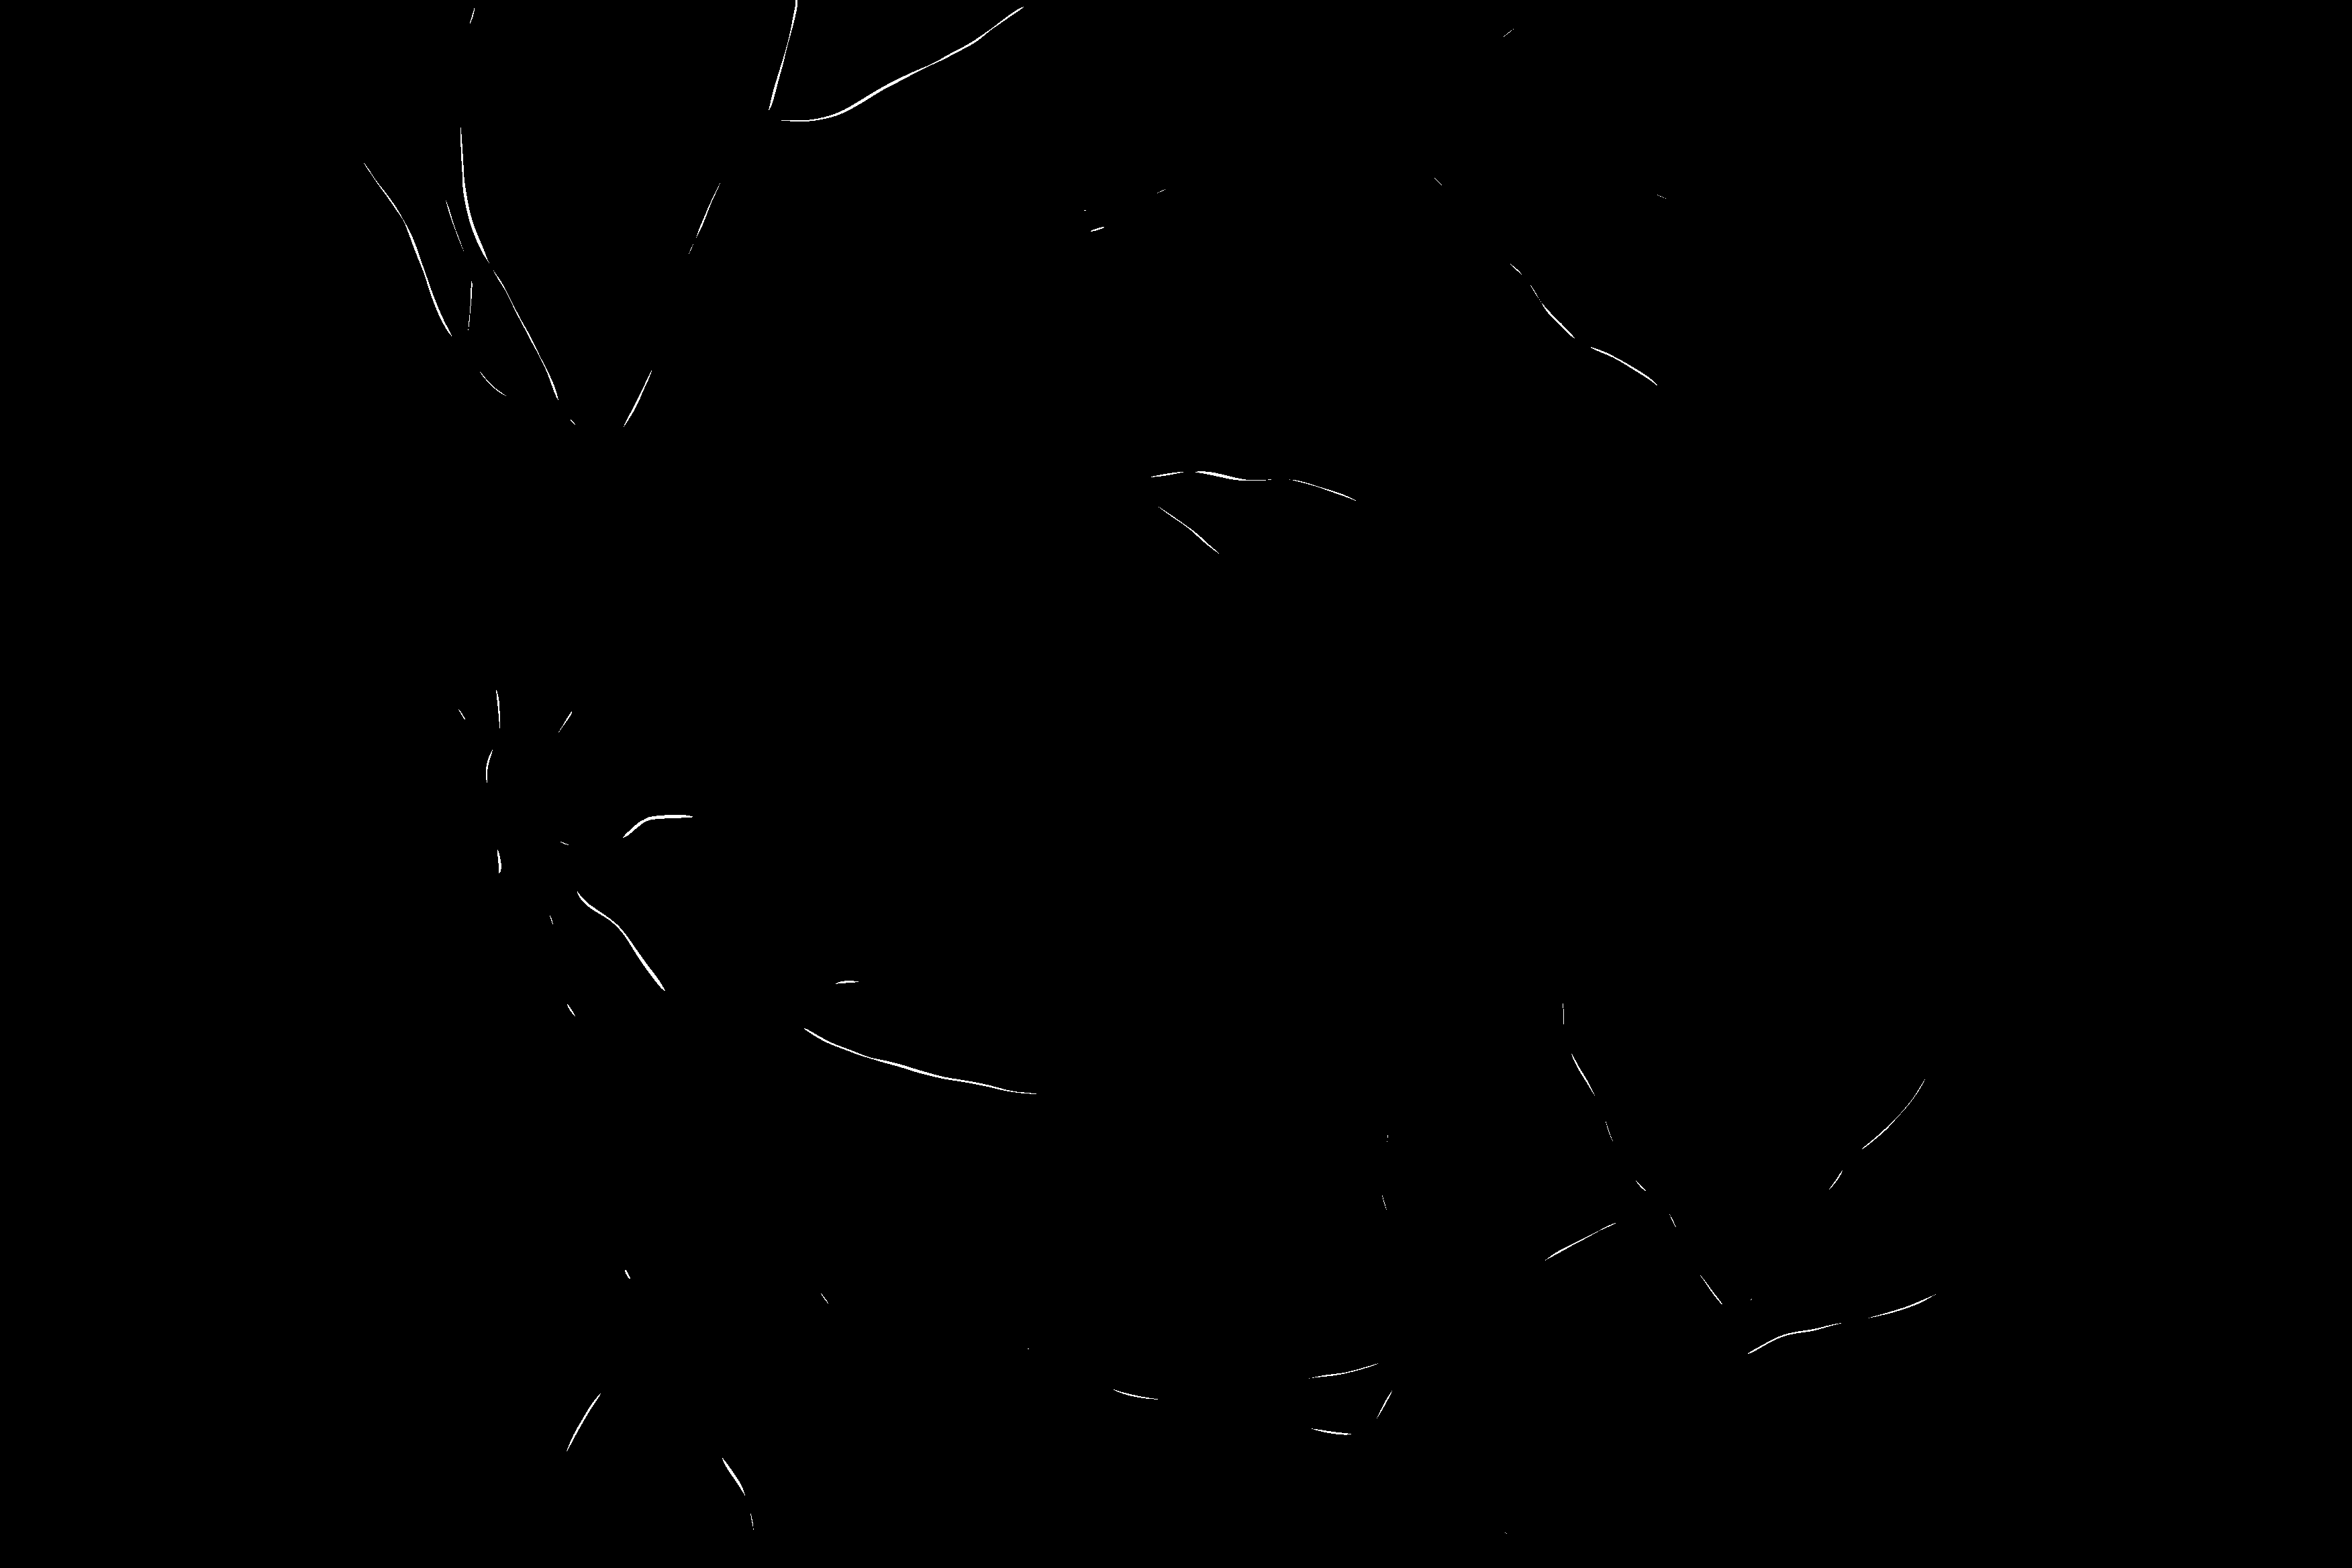

In [15]:
IMG.fromarray(255-img.img_skeleton)

In [16]:
lattice = Lattice(image_arr_2d=img.img_gabor)

In [ ]:
lattice.generate_lattice_graph(eight_connected=IMG_LATTICE_EIGHT_CONNECTED)

INFO:root:Creating 4-connected lattice.


In [2]:
import preprocess.algorithms.fast_mst as fmst

ImportError: No module named 'preprocess'

In [1]:
graph = fmst.run_segmentation(image_object=img,
                      lattice_object=lattice,
                      seed_list=seed_node_list,
                      segmentation_threshold=SEGMENTATION_THRESHOLD,
                      alpha=IMG_LATTICE_COST_ASSIGNMENT_ALPHA,
                      img_gabor_contribution=IMG_LATTICE_COST_GABOR_IMAGE_CONTRIBUTION,
                      img_original_contribution=IMG_LATTICE_COST_ORIGINAL_IMAGE_CONTRIBUTION)

NameError: name 'fmst' is not defined

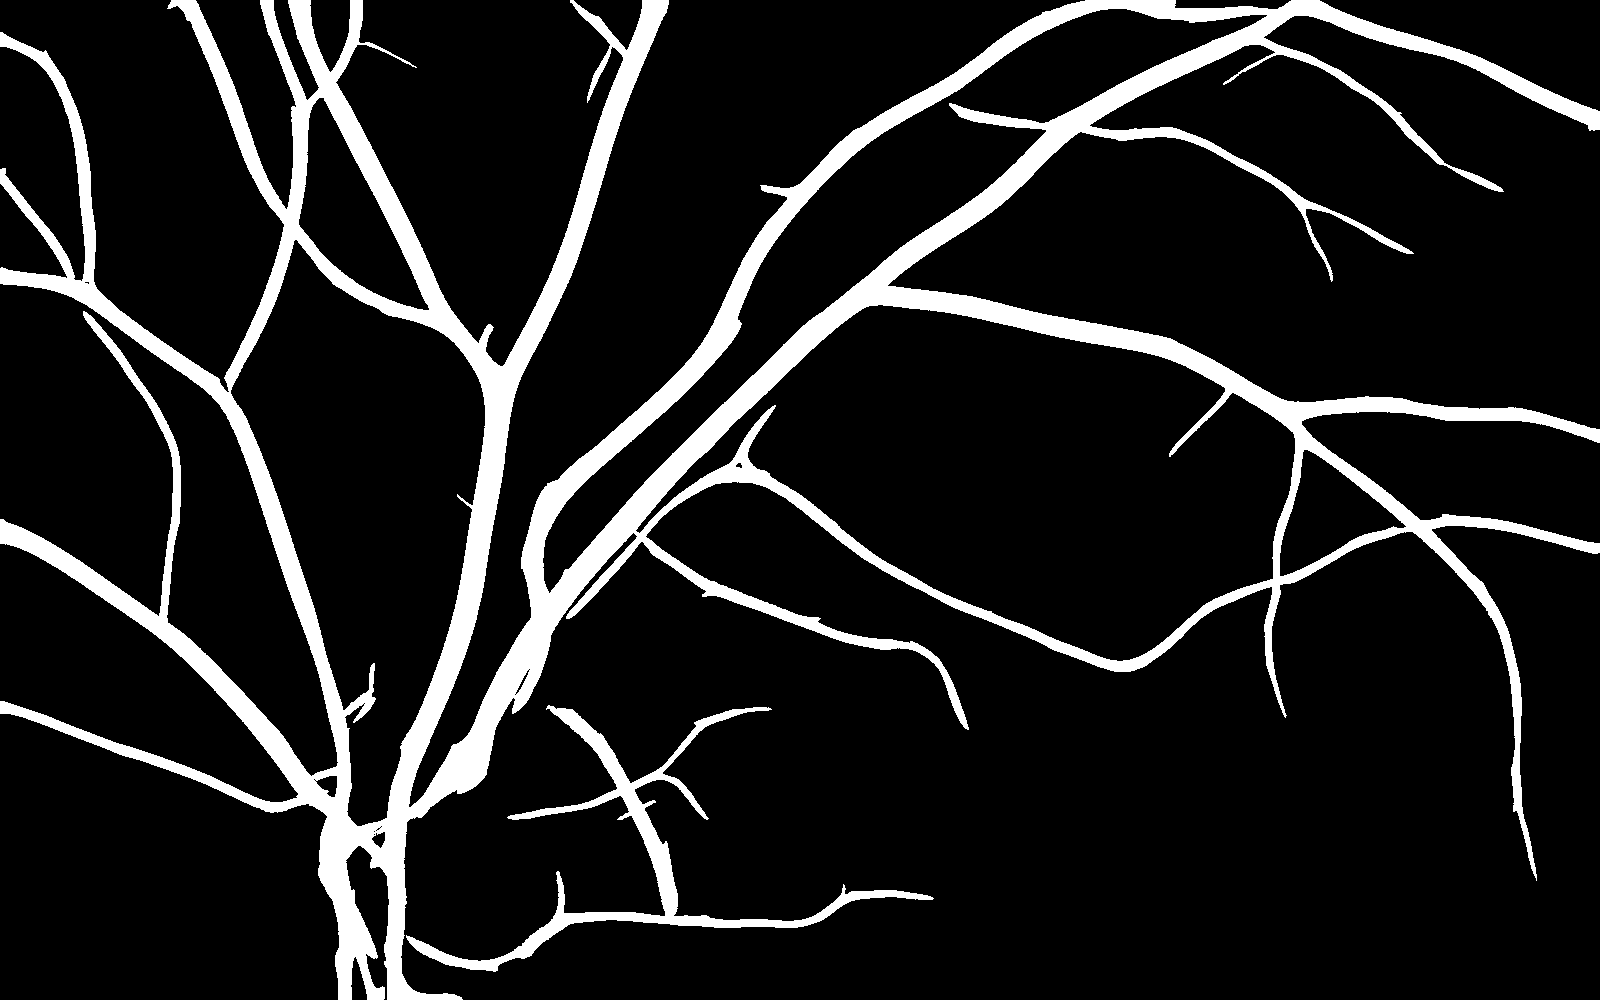

In [29]:
IMG.fromarray(lattice.accumulator)

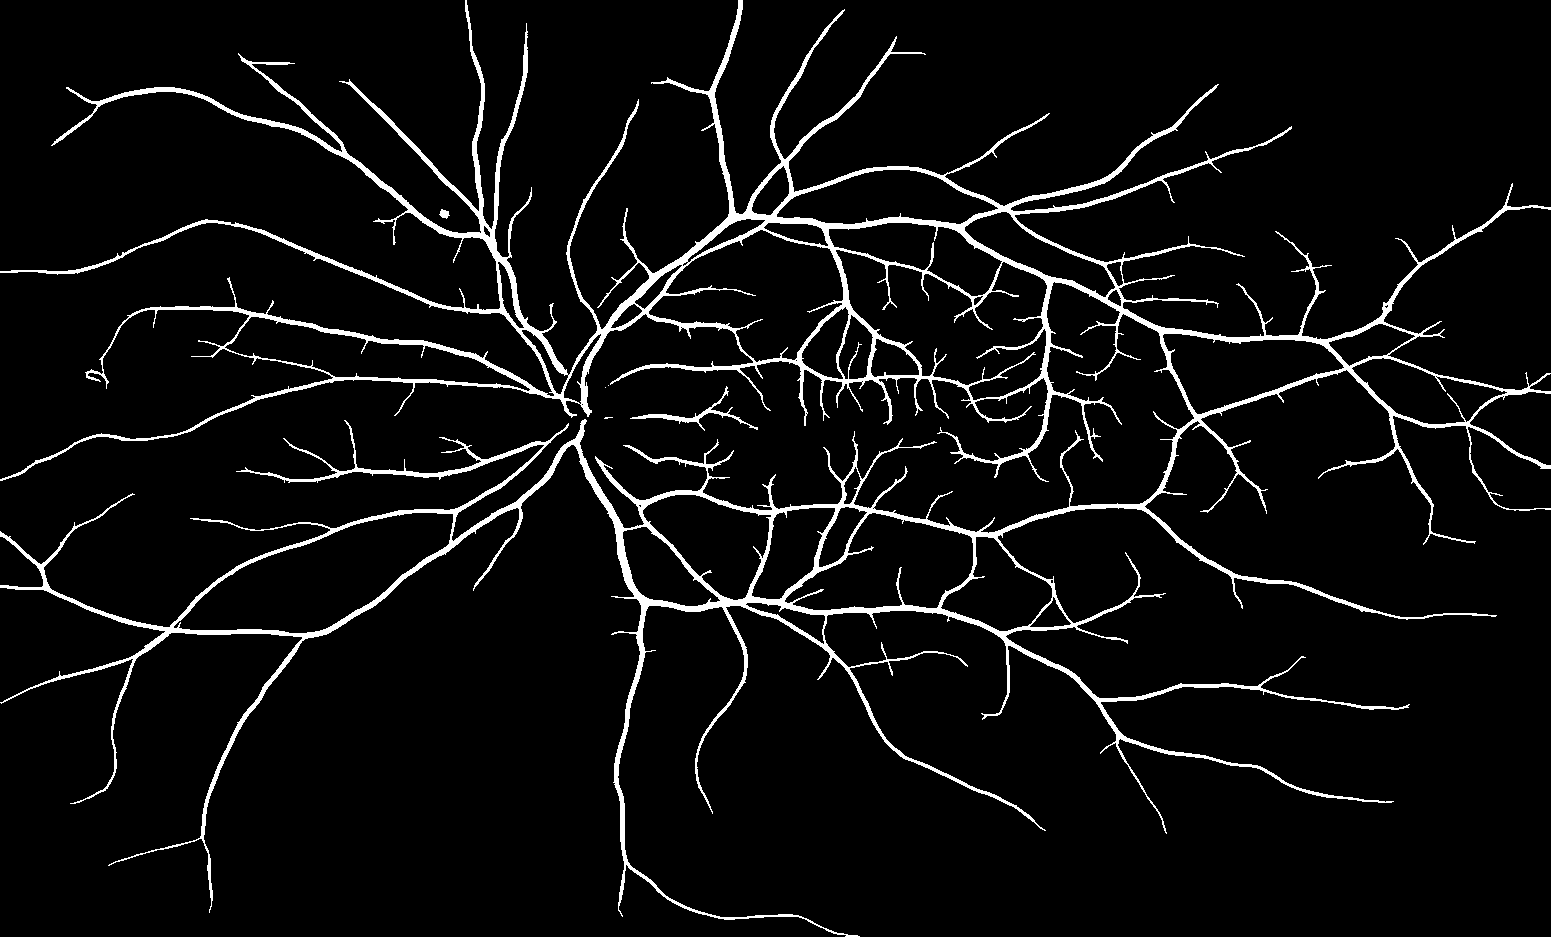

In [23]:
IMG.fromarray(lattice.accumulator)